# HW5. De Bruijn graph

In [16]:
import time
import seaborn as sns

from queue import Queue
from collections import Counter
from itertools import combinations, chain, count
from Bio import SeqIO
from graphviz import Source

In [17]:
CUTOFF_K = 2
CUTOFF_COV = 0.4


complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'} 


def rc(seq):
    """Reverse-complement sequence"""
    return ''.join(reversed([complement.get(base,base) for base in seq]))


def run_on_first(l, name):
    start_time = time.monotonic()
    g = DeBruijnGraph(f'data/graph/s_6.first{l}.fastq', 55)
    print(f'Init finished in {time.monotonic() - start_time:.2f} sec.')
    g.process_and_plot(name)
    print(f'Condencation finished in {time.monotonic() - start_time:.2f} sec with coverage: {g.avg_cov():.2f}.')
    g.to_fasta(f'db_graph/db_graph_{l}.fasta')
    g.to_png(f'db_graph/db_graph_{l}')
    return g.plot()

In [18]:
class Vertex:
    
    def __init__(self, seq, forward=True):
        self.seq = seq
        self.incoming = {}
        self.outcoming = {}
        self.complement = None
        self.forward = forward
        
    def add_outcoming(self, edge):
        self.outcoming[edge.seq] = edge
    
    def add_incoming(self, edge):
        self.incoming[edge.seq] = edge
        
    @property
    def is_linear(self):
        return (len(self.incoming) == 1) and (len(self.outcoming) == 1)
    
    @property
    def is_endpoint(self):
        return (len(self.incoming) == 1) and (len(self.outcoming) == 0)
    
    @property
    def is_startpoint(self):
        return (len(self.incoming) == 0) and (len(self.outcoming) == 1)
    
    @property
    def chain(self):
        if self.is_linear:
            return list(self.incoming.values())[0], list(self.outcoming.values())[0]
        
        if self.is_startpoint:
            return None, list(self.outcoming.values())[0]
        
        if self.is_endpoint:
            return list(self.incoming.values())[0], None
        
        return None, None
            

class Edge:
    
    def __init__(self, v_from, v_to, seq, cov=None, forward=True):
        self.v_from = v_from
        self.v_to = v_to
        self.seq = seq
        self.complement = None
        self.cov = cov or [1]
        self.forward = forward
        
    @classmethod
    def merge_edges(cls, edge_in, edge_out, k, forward):
        seq = edge_in.seq[:-k] + edge_out.seq
        cov = edge_in.cov + edge_out.cov
        
        return cls(edge_in.v_from, edge_out.v_to, seq, cov, forward=forward)
        
    @property
    def n_kmers(self):
        return len(self.cov)
    
    @property
    def size(self):
        return len(self.seq)
    
    @property
    def avg_cov(self):
        return sum(self.cov) / self.n_kmers


class DeBruijnGraph:
    
    def __init__(self, fasta_filepath, k=None):
        self.fasta_filepath = fasta_filepath
        self.edges = {}
        self.vertexes = {}
        self._new_label = count()
        self._build(k)
    
    def _build(self, k):
        self.k = k or self._find_k()
        print('Building vertexes.')
        self._build_vertexes()
        print('Building edges.')
        self._build_edges()
        self._cutoff_k = 2 * self.k
        self._cutoff_cov = self.avg_cov() * CUTOFF_COV
    
    @property
    def _reads(self):
        ext = self.fasta_filepath[-5:]
        return SeqIO.parse(open(self.fasta_filepath), ext)
    
    def _find_k(self):
        max_read_len = 0
        for read in self._reads:
            seq_len = len(read.seq)
            if seq_len > max_read_len:
                max_read_len = seq_len
        
        best_k = (max_read_len + 1) // 2
        best_k = best_k if best_k % 2 == 1 else best_k + 1
        print(f"--- K infered from reads: {best_k}.")
        return best_k
    
    def _add_vertex(self, seq):
        if seq not in self.vertexes:
            rc_seq = rc(seq)
            v_fwd = Vertex(seq, forward=True)
            v_bwd = Vertex(rc_seq, forward=False)
            v_fwd.complement = v_bwd
            v_bwd.complement = v_fwd
            self.vertexes[seq] = v_fwd
            self.vertexes[rc_seq] = v_bwd
            
    def _build_vertexes(self):
        for read in self._reads:
            sequence = str(read.seq)
            for i in range(0, len(sequence) - self.k + 1):
                self._add_vertex(sequence[i:i + self.k])
                
    def _add_edge(self, seq):
        rc_seq = rc(seq)
        if seq not in self.edges:
            seq_from, seq_to = seq[:-1], seq[1:]
            v_from, v_to = self.vertexes[seq_from], self.vertexes[seq_to]
            edge_fwd = Edge(v_from, v_to, seq, forward=True)
            v_from.add_outcoming(edge_fwd)
            v_to.add_incoming(edge_fwd)
            self.edges[seq] = edge_fwd
            
            seq_from, seq_to = rc_seq[:-1], rc_seq[1:]
            v_from, v_to = self.vertexes[seq_from], self.vertexes[seq_to]
            edge_bwd = Edge(v_from, v_to, rc_seq, forward=False)
            v_from.add_outcoming(edge_bwd)
            v_to.add_incoming(edge_bwd)
            self.edges[rc_seq] = edge_bwd
            
            edge_fwd.complement = edge_bwd
            edge_bwd.complement = edge_fwd
            
        else:
            self.edges[seq].cov[0] += 1
            self.edges[rc_seq].cov[0] += 1
            
    def _build_edges(self):
        for read in self._reads:
            sequence = str(read.seq)
            for i in range(0, len(sequence) - self.k):
                self._add_edge(sequence[i:i + self.k + 1])
                
    def avg_cov(self):
        n_kmers = 0
        total_cov = 0
        for seq, edge in self.edges.items():
            n_kmers += edge.n_kmers
            total_cov += sum(edge.cov)
        return total_cov / n_kmers
    
    def _cutoff_cov(self):
        return self.avg_cov() * CUTOFF_COV
    
    def remove_tails(self):
        remove_verts = []
        for seq, vertex in self.vertexes.items():
            if vertex.is_endpoint:
                edge_in, _ = vertex.chain
                if (len(edge_in.seq) < self._cutoff_k) or (edge_in.avg_cov < self._cutoff_cov):
                    edge_in.v_from.outcoming.pop(edge_in.seq)
                    remove_verts.append(seq)
                    self.edges.pop(edge_in.seq)
                
            if vertex.is_startpoint:
                _, edge_out = vertex.chain
                if (len(edge_out.seq) < self._cutoff_k) or (edge_out.avg_cov < self._cutoff_cov):
                    edge_out.v_to.incoming.pop(edge_out.seq)
                    remove_verts.append(seq)
                    self.edges.pop(edge_out.seq)
                    
        for seq in remove_verts:
            self.vertexes.pop(seq)
    
    def remove_bad_edges(self):
        remove_edges = []
        for seq, edge in self.edges.items():
            if (edge.avg_cov < self._cutoff_cov) and (len(edge.seq) < self._cutoff_k):
                edge.v_to.incoming.pop(seq)
                edge.v_from.outcoming.pop(seq)
                remove_edges.append(seq)
                
        for seq in remove_edges:
            self.edges.pop(seq)
    
    def polish_edges(self):
        remove_edges = []
        for seq, edge in self.edges.items():
            if (edge.avg_cov < 0.2 * self._cutoff_cov) or (len(edge.seq) < 0.2 * self._cutoff_k):
                edge.v_to.incoming.pop(seq)
                edge.v_from.outcoming.pop(seq)
                remove_edges.append(seq)
                
        for seq in remove_edges:
            self.edges.pop(seq)
            
    def _merge_vertex(self, vertex):
        edge_in, edge_out = vertex.chain
        
        new_edge = Edge.merge_edges(edge_in, edge_out, self.k, vertex.forward)
        edge_in.v_from.outcoming.pop(edge_in.seq)
        edge_in.v_from.outcoming[new_edge.seq] = new_edge
        edge_out.v_to.incoming.pop(edge_out.seq)
        edge_out.v_to.incoming[new_edge.seq] = new_edge

        self.edges.pop(edge_in.seq)
        self.edges.pop(edge_out.seq)
        self.edges[new_edge.seq] = new_edge
    
    def simplify(self):
        remove_verts = []
        visited = {}
        for vertex in self.vertexes.values():
            try:
                if vertex.is_linear and not visited.get(vertex, False):
                    for v in (vertex, vertex.complement):
                        visited[v] = True
                        self._merge_vertex(v)
                        remove_verts.append(v)
            except AttributeError as e:
                print(vertex.seq)
                print(e)
        for vert in remove_verts:
            self.vertexes.pop(vert.seq)
    
    def _combine_edges(self, edge1, edge2):
        edge1, edge2 = reversed(sorted([edge1, edge2], key=lambda x: x.avg_cov))
        edge2.v_to.incoming.pop(edge2.seq)
        edge2.v_from.outcoming.pop(edge2.seq)
        if len(edge1.cov) == len(edge2.cov):
            edge1.cov = [x + y for x, y in zip(edge1.cov, edge2.cov)]
        return edge2.seq
    
    def solve_parallel(self):
        remove_edges = []
        for vertex in self.vertexes.values():
            if len(vertex.outcoming) >= 2:
                for edge1, edge2 in combinations(vertex.outcoming.values(), 2):
                    if edge1.v_to == edge2.v_to: 
                        remove_edges.append(self._combine_edges(edge1, edge2))
                                
            if len(vertex.incoming) >= 2:
                for edge1, edge2 in combinations(vertex.incoming.values(), 2):
                    if edge1.v_from == edge2.v_from: 
                        remove_edges.append(self._combine_edges(edge1, edge2))
                
        for seq in remove_edges:
            self.edges.pop(seq)
            
    def process_and_plot(self, name):
        print('Starting condencation.')
        self.simplify()
        self.to_png(f'images/simpl_db_graph_{name}')
        self.remove_bad_edges()
        self.remove_tails()
        self.simplify()
        self.to_png(f'images/no_tails_db_graph_{name}')
        self.solve_parallel()
        self.simplify()
        self.to_png(f'images/no_bubbles_db_graph_{name}')
        for i in range(20):
            self.remove_bad_edges()
            self.remove_tails()
            self.simplify()
            self.solve_parallel()
            self.polish_edges()
            self.simplify()
        self.to_png(f'images/final_{name}')
        
    
    def process(self):
        print('Starting condencation.')
        self.simplify()
        self.remove_tails()
        self.simplify()
        self.solve_parallel()
        self.simplify()
    
            
    def dot_graph_with_pairs(self):
        graph_verts = {}
        i = 0
        s = 'digraph new_graph {\n'
        for seq, edge in self.edges.items():
            if not visited_edges.get(seq, False):
                label_from = graph_verts.get(edge.v_from.seq, None)
                if label_from is None:
                    label_from = f'V{i}'
                    graph_verts[edge.v_from.seq] = label_from
                    i += 1
                label_to = graph_verts.get(edge.v_to.seq, None)
                if label_to is None:
                    label_to = f'V{i}'
                    graph_verts[edge.v_to.seq] = label_to
                    i += 1

                s += f'    {label_from} -> {label_to} [label="len: {edge.size}, cov: {edge.avg_cov:.0f}"];\n'
        s += '}\n'
        return s
    
    def _get_label(self, edge, graph_verts):
        label_from = graph_verts.get(edge.v_from.seq, None)
        if label_from is None:
            label_from = f'V{next(self._new_label)}'
            graph_verts[edge.v_from.seq] = label_from
            
        label_to = graph_verts.get(edge.v_to.seq, None)
        if label_to is None:
            label_to = f'V{next(self._new_label)}'
            graph_verts[edge.v_to.seq] = label_to
        
        return label_from, label_to
            
    def dot_graph(self):
        self._new_label = count()
        graph_verts = {}
        s = 'digraph new_graph {\n'
        not_visited_edges = list(self.edges)
        queue = Queue()
        while len(not_visited_edges) > 0:
            if queue.empty():
                edge_seq = not_visited_edges.pop()
                if rc(edge_seq) != edge_seq:
                    not_visited_edges.remove(rc(edge_seq))
                queue.put(edge_seq)
            edge_seq = queue.get()
            edge = self.edges[edge_seq]
            for edge_seq in chain(list(edge.v_to.incoming), list(edge.v_to.outcoming), 
                              list(edge.v_from.incoming), list(edge.v_from.outcoming)):
                if edge_seq in not_visited_edges:
                    queue.put(edge_seq)
                    not_visited_edges.remove(rc(edge_seq))
                    not_visited_edges.remove(edge_seq)
            label_from, label_to = self._get_label(edge, graph_verts)
            s += f'    {label_from} -> {label_to} [label="len: {edge.size}, cov: {edge.avg_cov:.0f}"];\n'
        s += '}\n'
        return s
    
    def plot(self):
        return Source(self.dot_graph())
    
    def to_png(self, filename=None):
        self.plot().render(filename, format='png')
    
    def to_dot(self, filename):
        with open(filename, 'w') as f:
            f.write(self.dot_graph())
    
    def to_fasta(self, filename):
        with open(filename, 'w') as f:
            for i, edge in enumerate(self.edges):
                if self.edges[edge].forward:
                    f.write(f'>contig_{i}\n')
                    f.write(edge + '\n')

## Try on real data
### Estimate kmer coverage

1000000
2000000


Text(0.5, 1.0, 'K-mer coverage.')

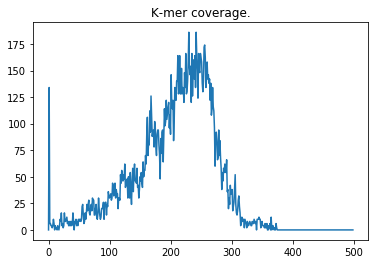

In [19]:
def kmer_generator(file, k):
    ext = file[-5:]
    fasta = SeqIO.parse(open(file), ext)
    l = 0
    for read in fasta:
        sequence = str(read.seq)
        for i in range(0, len(sequence) - k + 1):
            seq = sequence[i:i + k]
            l += 1
            if l % 1000000 ==0:
                print(l)
            yield seq
            yield rc(seq)
            

file, k = f'data/graph/s_6.first10000.fastq', 55
kmer_count = Counter(kmer_generator(file, k))
frequence_count = Counter(kmer_count.values())

X = list(range(500))
Y = [frequence_count[x] for x in X]
sns.lineplot(X, Y).set_title('K-mer coverage.')

Kmer minimum coverage is set to ~ 100.
### s_6.first1000.fastq

Building vertexes.
Building edges.
Init finished in 1.11 sec.
Starting condencation.
Condencation finished in 2.07 sec with coverage: 155.68.


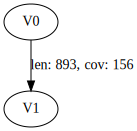

In [20]:
l = 1000
name = f'first{l}'
run_on_first(l, name)

### s_6.first10000.fastq

Building vertexes.
Building edges.
Init finished in 17.23 sec.
Starting condencation.
Condencation finished in 18.41 sec with coverage: 204.02.


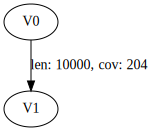

In [21]:
l = 10000
name = f'first{l}'
run_on_first(l, name)

### s_6.first100000.fastq

Building vertexes.
Building edges.
Init finished in 200.65 sec.
Starting condencation.
Condencation finished in 216.16 sec with coverage: 224.98.


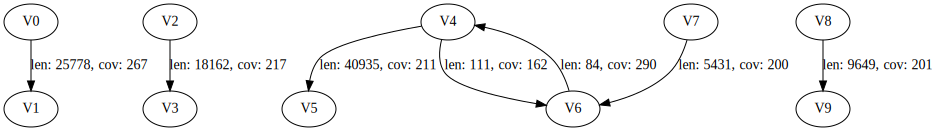

In [22]:
l = 100000
name = f'first{l}'
run_on_first(l, name)

Получились контиги длиной 40935, 25778, 18162, 9649, 5431.  
Общаяя длина: 99955 из 100000.

## Final Thoughts

Я использовал и отбрасывание хвостиков и удаление "плохих" ребер.  
Мне кажется, что если не использовать какое-то исправление графа типа "Bus tour" стоит использовать оба метода, так как ребра с покрытием в десятки раз меншьше среднего не несут много полезной информации.   
Однако отбрасывание хвостиков можно делать более свободно(установить более жесткий отбор по длине и покрытию), так как они не влияют на связанность графа.  
В то же время если выкинуть не очень качественное ребро, можно "разорвать" граф. Это надо делать аккуратнее.  

Картинки и получившися фаста файл можно найти в папке db_graph.
* final_first*.png - полностью обработанный граф.
* simpl_db_graph_first*.png - сжатый граф до удаления плохих ребер и хвостиков.
* db_graph_*.fasta - получившиеся ребра.